In [1]:
import random
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import fitstools
from pathlib import PurePath
import glob
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from balltracking import mballtrack as mblt
from skimage.feature import blob_log, blob_dog, peak_local_max
from matplotlib.patches import Ellipse


plt.rcParams.update({'font.size': 12})
dpi = 168
DTYPE = np.float32

In [2]:
def prep_data(image):
    image2 = np.abs(image)
    image3 = image2.max() - image2
    surface = (image3 - image3.mean())/image3.std()
    return surface.copy(order='C').astype(DTYPE)

def add_colorbar(axes, image_object):
    # position for the colorbar
    divider = make_axes_locatable(axs)
    cax = divider.append_axes('right', size='1%', pad=0.3)
    # Adding the colorbar
    cbar = plt.colorbar(im, cax=cax)
    return cbar

In [60]:
# Data prepped by COR2_tracking_prep.ipynb
datadir = PurePath(os.environ['DATA'], 'STEREO/L7tum/prep_fits')
outputdir = PurePath(os.environ['DATA'], 'STEREO/L7tum/')
datafiles = sorted(glob.glob(str(PurePath(datadir, '*.fits'))))
nfiles = len(datafiles)
nsamples = 10

image = fitstools.fitsread(datafiles[0], cube=False)
blob_thresh = 1.0
overlap = 0.6

surface_inv = -prep_data(image)
blobs_dog = blob_dog(surface_inv, overlap=overlap, threshold=blob_thresh, min_sigma=[6, 2], max_sigma=[20, 10])

init_pos = np.fliplr(blobs_dog[:, 0:2]).T

mbt_dict = {"nt": nsamples,
            "rs": 4,
            "am": 1,
            "dp": 0.3,
            "tdx": 1,
            "tdy": 100,
            "zdamping": 1,
            "ballspacing": 15,
            "intsteps": 20,
            "mag_thresh": 3.5,
            "noise_level": 2,
            "track_emergence": False,
            "prep_function": prep_data,
            "datafiles": datafiles,
            "init_pos": init_pos,
            "do_plots": False,
            "astropy": True,
            "verbose": False,
            "outputdir": datadir,
            "fig_dir": PurePath(datadir, 'figures')}

In [4]:
mbt = mblt.MBT(polarity=1, **mbt_dict)

nballs_max = 1552


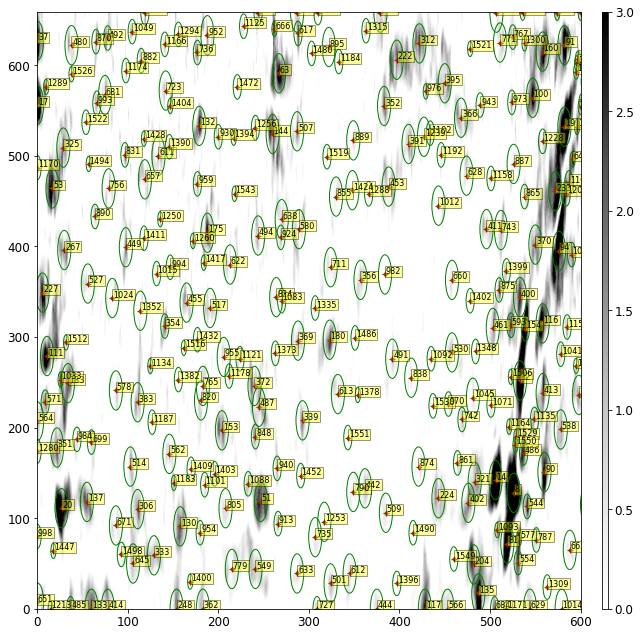

In [5]:
n = 0
# Load the image at the current time index
image = fitstools.fitsread(datafiles[n], cube=False)

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(10, 9))
im = axs.imshow(-mbt.surface, vmin=0, vmax=3, origin='lower', cmap='Greys')
cbar = add_colorbar(axs, im)

for b, blob in enumerate(blobs_dog):
    blob_label = str(b)
    y, x, sigma_rows, sigma_cols = blob
    ry = sigma_rows * np.sqrt(2) * 2
    rx = sigma_cols * np.sqrt(2) * 2
    ell = Ellipse((x, y), rx, ry, linewidth=1, fill=False, color='green', linestyle='-')
    axs.add_artist(ell)
    axs.plot(x, y, 'g.')
    axs.text(x+1, y+1, blob_label, color='black', fontsize=8,
             bbox=dict(facecolor='yellow', alpha=0.4, edgecolor='black', pad=1), clip_on=True)

if n == 0:
    axs.plot(mbt.xstart, mbt.ystart, 'r+')


axs.set_xlim([0, 600])
axs.set_ylim([0, 659])

plt.tight_layout()

Have a look at the local peaks within each ellipse: 
Must get the points satisfying (x - xc)^2/a^2 + (y - yc)^2/b^2 < 1 with (xc, yc) center of ellipse, a, b semi-major and semi-minor axis. 

In [65]:
def make_ell_points(xc, yc, a, b, imshape):
    
    a *= np.sqrt(2)
    b *= np.sqrt(2)
    ellgridx = np.arange(xc - a, xc + a + 1, dtype=np.int32)
    ellgridy = np.arange(yc - b, yc + b + 1, dtype=np.int32)
    xx, yy = np.meshgrid(ellgridx, ellgridy)
    ell_x = []
    ell_y = []
    for x, y in zip(xx.ravel(), yy.ravel()):
        if x > 0 and y > 0 and x < imshape[1] and y < imshape[0] and (x - xc)**2/a**2 + (y - yc)**2/b**2 <= 1:
            ell_x.append(x)
            ell_y.append(y)
            
    return ell_x, ell_y

In [66]:
a = 5
b = 10
xc, yc = 15, 20

ell_x, ell_y = make_ell_points(xc, yc, a, b, image.shape)
mask = np.zeros([40, 40])
mask[ell_y, ell_x] = 1

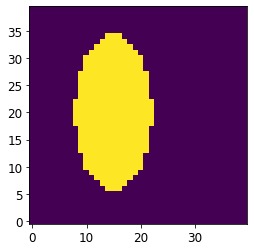

In [67]:
plt.figure()
plt.imshow(mask, origin='lower')

In [68]:
label_mask = np.zeros(image.shape, dtype=np.int64)
for i, blob in enumerate(blobs_dog):
    yc, xc, b, a = blob
    ell_x, ell_y = make_ell_points(xc, yc, a, b, image.shape)
    label_mask[ell_y, ell_x] = i+1

In [69]:
peaks = peak_local_max(surface_inv, labels=label_mask, num_peaks_per_label=1)
peaks.shape, blobs_dog.shape

((1551, 2), (1552, 4))

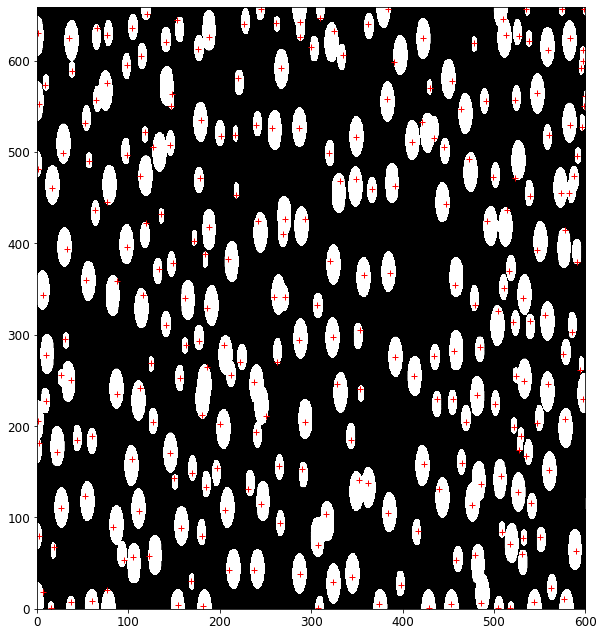

In [70]:
plt.figure(figsize=(10,9))
plt.imshow(label_mask, origin='lower', vmin=0, vmax=1, cmap='gray')
plt.plot(peaks[:,1], peaks[:,0], 'r+')
plt.xlim([0, 600])
plt.ylim([0, 659])

plt.tight_layout()

Keep only the peaks that are within a reasonnable distance from the edges of the ellipses

In [16]:
label_mask = np.zeros(image.shape, dtype=np.int64)
yc, xc, b, a = blobs_dog[0]
ell_x, ell_y = make_ell_points(xc, yc, a, b, image.shape)
label_mask[ell_y, ell_x] = 1
peak = peak_local_max(surface_inv, labels=label_mask, num_peaks_per_label=1)
peak

array([[ 308, 3125]])

(704, 2)

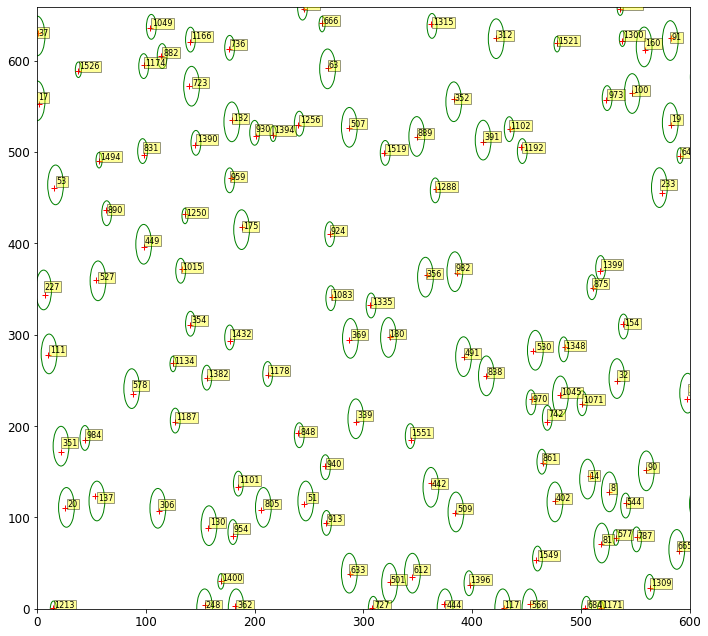

In [84]:
plt.close('all')
fig, axs = plt.subplots(figsize=(10,9))

axs.set_xlim([0, 600])
axs.set_ylim([0, 659])

plt.tight_layout()

peaks = []
for i, blob in enumerate(blobs_dog):
    yc, xc, b, a = blob
    ry = b * np.sqrt(2)
    rx = a * np.sqrt(2)
    ell_x, ell_y = make_ell_points(xc, yc, rx, ry, image.shape)
    label_mask = np.zeros(image.shape, dtype=np.int64)
    label_mask[ell_y, ell_x] = 1
    peak = peak_local_max(surface_inv, labels=label_mask, num_peaks_per_label=1)
    # Only consider if close enough from the geometric center of the ellipse
    if len(peak) > 0:
        ypeak, xpeak = peak[0]
        # print(i, xc, yc, a, b)
        ry = b * np.sqrt(2)
        rx = a * np.sqrt(2)
        xrel = abs(peak[0][1] - xc)/rx
        yrel = abs(peak[0][0] - yc)/ry
        if xrel <= 0.3 and yrel <= 0.3:
            ell = Ellipse((xc, yc), rx*2, ry*2, linewidth=1, fill=False, color='green', linestyle='-')
            axs.add_artist(ell)
            peaks.append(peak[0])
            axs.plot(xpeak, ypeak, 'r+')
            axs.text(xc+1, yc+1, str(i), color='black', fontsize=8,
             bbox=dict(facecolor='yellow', alpha=0.4, edgecolor='black', pad=1), clip_on=True)

            
peaks = np.array(peaks)
peaks.shape

In [44]:
peaks

array([[ 308, 3125],
       [  57, 3161],
       [ 266, 1747],
       [ 597, 3075],
       [ 318, 3287],
       [ 128,  526],
       [ 145,  508],
       [ 380, 3506],
       [ 553,    2],
       [   8, 2622],
       [ 652,  613],
       [ 164, 3552],
       [ 627, 3596]])